# Introduction

Basic exploratory analysis of stores will be carried out in this notebook.

In [1]:
%load_ext autoreload
%autoreload


import pathlib
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


%matplotlib inline
sns.set_style("darkgrid")

# Constants

In [2]:
ROOT_PATH = pathlib.Path("../../")
DATA_PATH = ROOT_PATH.joinpath("_data")

# Import data

In [3]:
store = pd.read_csv(DATA_PATH.joinpath("store.csv").resolve())

# Handle missings

Let's check the scale of missing values in the above loaded set.

In [4]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Now we will try to encode each missing in a more informative way.

We will start with the `CompetitionDistance` variable in which only three missings were observed.
Let's print them out.

In [5]:
store.loc[pd.isna(store["CompetitionDistance"]), :]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


The reason why they have no competition highlighted may be due to the fact that there is no competition at all near those stores.
Let's investigate this suspicion by checking the maximum distances to the competition recorded in the data set.

In [6]:
print(
    "Maximum competition's distance provided in the data set is: {0:.2f} km."
    .format(store["CompetitionDistance"].max() / 1000)
)

Maximum competition's distance provided in the data set is: 75.86 km.


Judging by the prism of the distances' range span it is almost impossible that, if observed, there would be no data provided, so we will fill those 3 missings with the means of corresponding types of stores. 

In [7]:
store["CompetitionDistance"] = store.groupby("StoreType")["CompetitionDistance"].transform(
    lambda x: x.fillna(np.round(x.mean(), decimals=-1))
)

Now let's move on to the rest of the variables prefixed with the `Competition`.
We can clearly see that the number of missings in both of those variables is the same and it concerns $\frac{1}{3}$ of the data set.
Let's review the example records that are affected by those missings.

In [8]:
store.loc[pd.isna(store["CompetitionOpenSinceMonth"]), :].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


We can see that the distance to the nearest competition for these cases is given, so replacing these NaNs with a mean would be naive.


From the perspective of later modeling, an important piece of information that I would like to draw from the opening date of the competition is whether at the moment the store functioned in an environment without nearby competition so for stores where no competition opening data is available we will assume that the competition was there the whole time (so missing values will be replaced with a very distant date).

In [9]:
store["CompetitionOpenSinceDate"] = pd.to_datetime(
    store.CompetitionOpenSinceYear * 100 + store.CompetitionOpenSinceMonth,
    format="%Y%m"
)

store["CompetitionOpenSinceDate"].fillna(
    pd.Timestamp(year=1900, month=1, day=1),
    inplace=True
)

The last category of missing values are those prefixed with the `Promo` word.
these deficiencies are probably caused by the non-participation of the store in promotions.

In [10]:
def count_null(series):
    return series.isnull().sum()


PROMO_FEATURES = ["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]
store.groupby("Promo2")[PROMO_FEATURES].agg(count_null)

,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Promo2,,,
0,544.0,544.0,544
1,0.0,0.0,0


Now we can clearly see that missings here are caused by the lack of participation in promotions.
We would like to use this information to detect months when the store was actively participating in the promo2 so we will replace missings with a future date to always reject the assignment (the date of participation in the promotion will be the date from the future what will always assign flag "not participating in promo2 yet").

In [11]:
store["Promo2SinceDate"] = pd.to_datetime(
    store["Promo2SinceYear"] * 1000 + store["Promo2SinceWeek"] * 10 + 1,
    format="%Y%W%w"
)

store["Promo2SinceDate"].fillna(
    pd.Timestamp(year=2100, month=1, day=1),
    inplace=True
)

Eventually we will make a `PromoInterval` encoding and stores that are not participating in the promotions will have assigned -1 value.

In [12]:
print(
    "Unique `PromoInterval` categories: {}"
    .format(store["PromoInterval"].unique())
)

Unique `PromoInterval` categories: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [13]:
def encode_promo_interval(cell):
    if pd.isna(cell):
        return -1
    elif cell.startswith("Jan"):
        return 1
    elif cell.startswith("Feb"):
        return 2
    else:
        return 3


store["PromoIntervalType"] = store["PromoInterval"].apply(encode_promo_interval)

# EDA

## Distributions

In the first place we want to become familiar with distributions of features present in our data set.
That includes:

* numerousness of unique categories for discrete variables
* quantiles of continuous variables
* interactions between continuous and discrete type variables

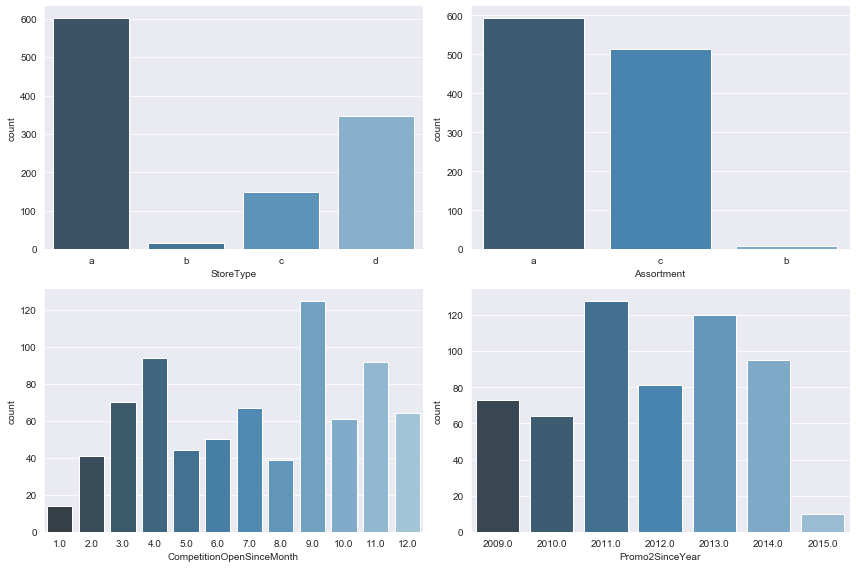

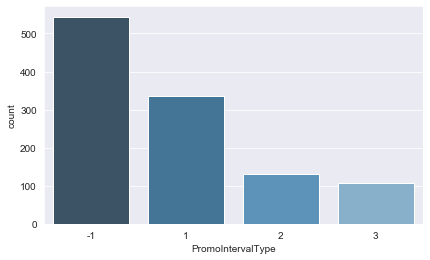

In [14]:
from paralytics.utils import multipleplots


COLUMNS_TO_VISUALIZE_COUNTS = [
    "StoreType", "Assortment", "CompetitionOpenSinceMonth", "Promo2SinceYear"
]

multipleplots(
    x=COLUMNS_TO_VISUALIZE_COUNTS,
    data=store.sort_values(by="StoreType"),
    nrows=2,
    ncols=2,
    figsize=(12, 8),
    plot_type="countplot",
    palette="Blues_d"
    
)
sns.despine()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6.8, 4))
sns.countplot(x="PromoIntervalType", data=store, palette="Blues_d", ax=ax)
plt.show()

What we can observe is:

* **type a** stores prevail in the data set,
* only a few stores have an assortment of **type b**,
* competition relatively **rarely opens new stores during the holiday** season compensating it in September,
* the number of stores participating in the **promo2** was saturated up to and including **2014**,
* most of the stores **distribute discount coupons** in the **first month of each quarter**.

## Promo2

Below analyze of the variables regarding the start date for distributing discount coupons will be conducted.

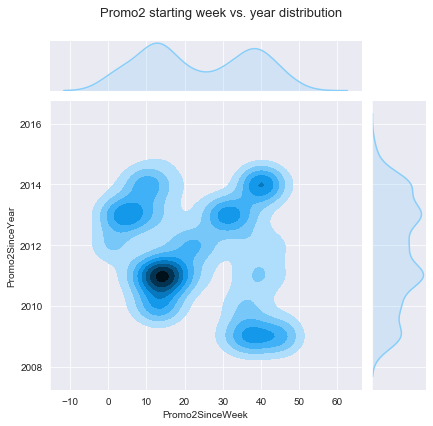

In [15]:
g = sns.jointplot(
    x="Promo2SinceWeek", 
    y="Promo2SinceYear", 
    data=store, 
    kind="kde", 
    color="lightskyblue"
)
g.ax_joint.collections[0].set_alpha(0)
g.fig.suptitle("Promo2 starting week vs. year distribution", size=13)
plt.subplots_adjust(top=.9)

plt.show()

From the above chart we can see that the largest concentration of starting sending discount coupons took place between 2010 and 2012 years, starting in mid-March and ending at the end of May.


Another observation can be made about the weeks in which stores joined the `promo2` and note that the distribution of these weeks is close to the bimodal distribution with picks around **12th** and **38th** week.

Now let's take a closer look on the competition starting month vs. year comparison broken down into types of stores.

## Competition

We will visualize the dependencies between the variables concerning the competition of a given store.

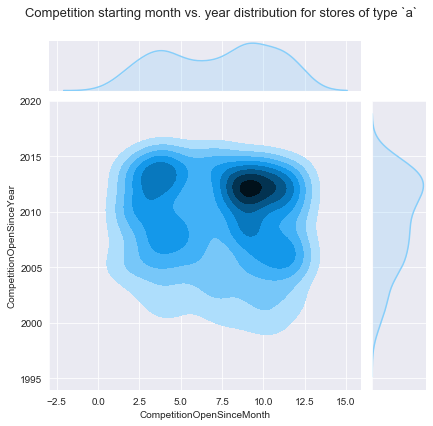

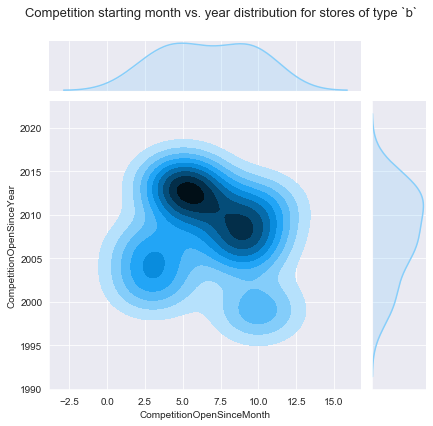

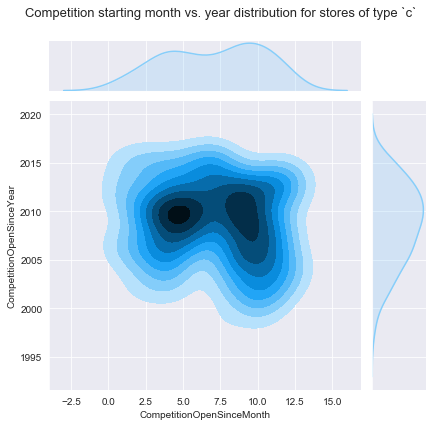

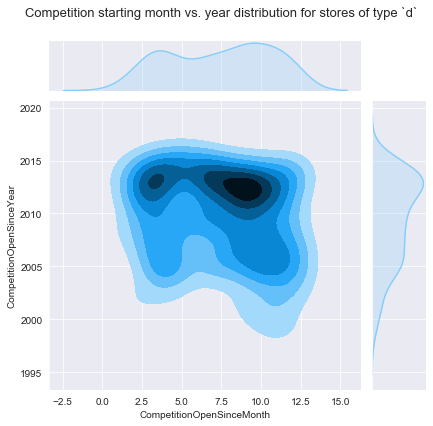

In [16]:
for store_type in sorted(store["StoreType"].unique()):
    g = sns.jointplot(
        x="CompetitionOpenSinceMonth", 
        y="CompetitionOpenSinceYear", 
        data=store[
            (store["CompetitionOpenSinceYear"] > 1995) 
            & (store["StoreType"] == store_type)
        ],
        kind="kde",
        color="lightskyblue"
    )
    g.ax_joint.collections[0].set_alpha(0)
    g.fig.suptitle(
        "Competition starting month vs. year distribution for stores of type `{}`"
        .format(store_type),
        size=13
    )
    plt.subplots_adjust(top=.9)

plt.show()

We can observe that those distributions are fairly similar, but with each subsequent type of stores the main cluster is centralizing.

What about the average distance to the closest competitor? Let's find out.

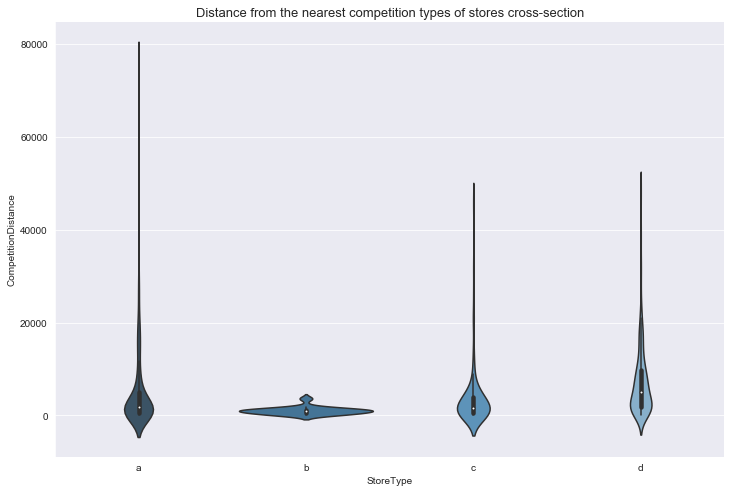

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.violinplot(
    x="StoreType",
    y="CompetitionDistance",
    data=store.sort_values(by="StoreType"),
    palette="Blues_d",
    ax=ax
)
ax.set_title(
    "Distance from the nearest competition types of stores cross-section",
    size=13
)
sns.despine()

plt.show()

The graph above shows us that the joint distributions of these variables strive toward the product of marginal distributions of each variable separately with the exception of "b" type stores, which are characterized by high concentration near the median. 
However, it should be borne in mind that these types of stores are underrepresented in our data set and this characteristic might change.

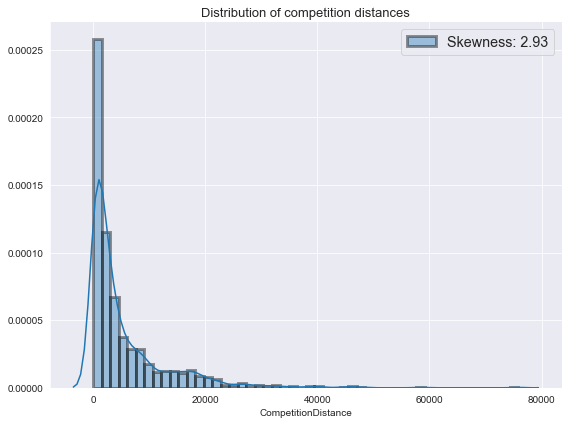

Fraction of competitive stores being closer than 1 km from the store: 0.30.


In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

competition_distance = store["CompetitionDistance"]
sns.distplot(
    competition_distance,
    hist_kws={"edgecolor": "black", "linewidth": 3},
    label=f"Skewness: {competition_distance.skew():.2f}"
)
ax.legend(fontsize="x-large")
ax.set_title("Distribution of competition distances", size=13)
sns.despine()
plt.tight_layout()

plt.show()

print(
    "Fraction of competitive stores being closer "
    "than 1 km from the store: {0:.2f}."
    .format(np.sum(store["CompetitionDistance"] <= 1000) / len(store))
)

The vast majority of competition is located within 1 kilometer from the store (30% of stores have competition in this area).

## Analyze the impact on sales

We will try to find a link between the variables regarding the stores and the average sales volume over the period under consideration in the given store.
For this purpose, we must read the data from the `train.csv` file and aggregate the sales volume.

In [19]:
train = pd.read_csv(DATA_PATH.joinpath("train.csv"), low_memory=False)

train["Date"] = pd.to_datetime(train["Date"])

train = train.assign(
    Year=lambda df: df["Date"].dt.year,
    Month=lambda df: df["Date"].dt.month,
    Day=lambda df: df["Date"].dt.day
)

Let's investigate whether for all stores observations for the same time span are provided.

In [20]:
train_counts = train.groupby("Store")["Date"].agg("count")
print(
    "Number of different number of observations for a single store is: {} (that is: {})."
    .format(
        train_counts.nunique(),
        ", ".join(sorted(train_counts.unique().astype(str)))
    )
)

Number of different number of observations for a single store is: 3 (that is: 758, 941, 942).


This means that we are dealing with the unbalanced panel and we need to find out where are the differences in the number of observations for a single store.

Firstly we will check the **941** observations.

In [21]:
train[train["Store"].isin(train_counts[train_counts == 941].index)].tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
1011507,988,7,2013-01-06,0,0,0,0,0,0,2013,1,6
1012622,988,6,2013-01-05,3849,590,1,0,0,0,2013,1,5
1013737,988,5,2013-01-04,3940,646,1,0,0,1,2013,1,4
1014852,988,4,2013-01-03,4335,737,1,0,0,1,2013,1,3
1015967,988,3,2013-01-02,4992,829,1,0,0,1,2013,1,2


We can clearly see that the one missing observation is the first measurement period (2013-01-01).
We will leave it in this form, because it will not affect the method itself, but only reduce the number of available observations by one.

In [22]:
train_758_dates = set(
    train[
        train["Store"].isin(train_counts[train_counts == 758].index)
    ]["Date"].unique()
)

train_942_dates = set(
    train[
        train["Store"].isin(train_counts[train_counts == 942].index)
    ]["Date"].unique()
)

dates_diffs = list(train_942_dates.difference(train_758_dates))
dates_diffs.sort()

print(
    "Number of missing dates: {}\n"
    "Number of observations without those dates: {}\n"
    "First missing date is: {}\n"
    "Last missing date is: {}\n"
    .format(
        len(dates_diffs),
        len(train_counts[train_counts == 758]),
        pd.to_datetime(dates_diffs[0]).strftime('%Y.%m.%d'),
        pd.to_datetime(dates_diffs[-1]).strftime('%Y.%m.%d')
    )
)

Number of missing dates: 184
Number of observations without those dates: 180
First missing date is: 2014.07.01
Last missing date is: 2014.12.31



For 180 stores we have no second half-year observations.
This is a continuous interval, not single holes between dates, so we will make allowances for this when creating lagged variables and discard enough observations for which there will be missing data generated.

Now we can aggregate the sales at the store level. 
We will take only into consideration days when the store was open.

In [23]:
store_sales_avg = train[train["Open"] == 1].groupby("Store")["Sales"].agg("mean")

store = store.merge(
    right=store_sales_avg,
    how="left",
    left_on="Store",
    right_index=True
)

Firstly we will see how types of store affects the average sales level.

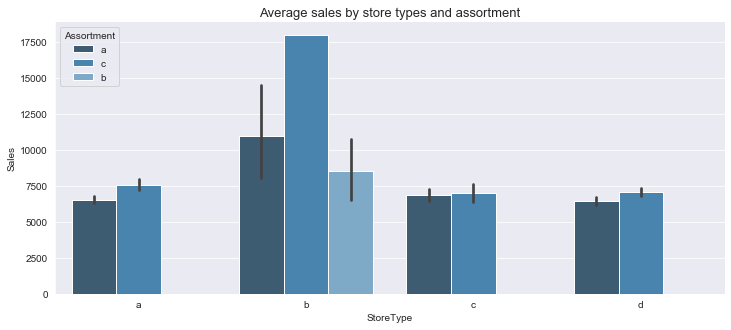

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(
    x="StoreType",
    y="Sales",
    data=store.sort_values(by="StoreType"),
    hue="Assortment",
    palette="Blues_d",
    ax=ax
)
ax.set_title(
    "Average sales by store types and assortment",
    size=13
)
sns.despine()

plt.show()

Bearing in mind the under-representation of **b-type** stores, we can see that the type of store does not have a major impact on the average level of sales.
Interesting observation is that the **b-type assortment is only present in b-type stores**.
We can hypothesize that "b" stores are more exclusive, hence their under-representation in the data set.

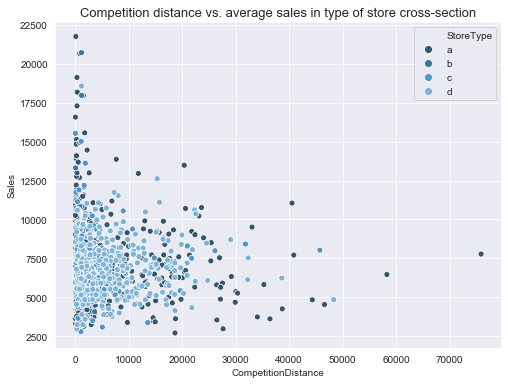

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    x="CompetitionDistance",
    y="Sales",
    hue="StoreType",
    data=store.sort_values(by="StoreType"),
    palette="Blues_d",
    ax=ax
)
ax.set_title(
    "Competition distance vs. average sales in type of store cross-section",
    size=13
)

plt.show()

The distance to the nearest competition does not indicate to affect the average sale.
We observe that, in cross-section for individual types of stores, no distinctive pattern can be determined.

# Modeling average sales

It seems interesting to check whether, based on the same invariant features over time - store characteristics, we are able to predict their average sales. If it turns out to have predictive potential, it will signal to us that during the construction of the model on panel data, **fixed effects estimator** (including time-invariant store-specific mean by adding a different intercept for each store) will be **consistent** (this can be asserted with the **Hausman test**).

In [26]:
# Removing fully collinear features and duplicated index (Store column).
df = store.drop(
    [
        "Store", "PromoInterval", "CompetitionOpenSinceMonth", 
        "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear"
    ],
    axis="columns"
)

y = df.pop("Sales")
X = df

We want to build a simple model and interpret which features drive the average sales from the one specified in the store.csv data set (if any).

The transformations that we will do before the modeling include:

* Encoding categorical features.
* Converting datetime features to features informing how many months have passed since the highlighted date.
* Discretizing newly created feature `CompetitionOpenFor` - no. of months since competition is open, to try to extract information from missing values, treating them as a separate category.

In [27]:
import statsmodels.api as sm

from paralytics import Discretizer
from sklearn.preprocessing import StandardScaler


actual_date = train.Date.max()

X[["CompetitionOpenFor", "Promo2For"]] = X[["CompetitionOpenSinceDate", "Promo2SinceDate"]].applymap(
    lambda col: len(pd.date_range(start=col, end=actual_date, freq="M"))
)

X.drop(["CompetitionOpenSinceDate", "Promo2SinceDate"], axis="columns", inplace=True)

X.loc[pd.isna(store["CompetitionOpenSinceMonth"]), "CompetitionOpenFor"] = np.nan

# Discretizing continuous feature containing NaNs (making them a category).
X[["CompetitionOpenFor"]] = Discretizer(method="spearman").fit_transform(
    X[["CompetitionOpenFor"]], y
)

# OHE categorical features.
X = pd.get_dummies(
    data=X,
    columns=["StoreType", "Assortment", "PromoIntervalType", "CompetitionOpenFor"],
    drop_first=True
)

# Standardize continuous features.
X[["CompetitionDistance", "Promo2For"]] = StandardScaler().fit_transform(
    X[["CompetitionDistance", "Promo2For"]]
)

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)
    X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     9.066
Date:                Tue, 06 Aug 2019   Prob (F-statistic):           6.00e-18
Time:                        23:17:14   Log-Likelihood:                -10196.
No. Observations:                1115   AIC:                         2.042e+04
Df Residuals:                    1101   BIC:                         2.049e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


The construction of the reference model predicting average sales based on stores data did not bring results allowing us to confirm the legitimacy of using a fixed effect estimator in further analysis.
The model does not fit the data well **($R^2 = 0.1$)** and its analytical value is negligible.

This may indicate that there are no significant differences between store characteristics that affect average sales, or these relations are non-linear.

# Pickling data

In [28]:
store.to_pickle(DATA_PATH.joinpath("store.pkl"))